# 01 - EDA & Feature Engineering


In [ ]:
import os, glob, gc, pandas as pd, numpy as np, warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
plt.rcParams["figure.figsize"] = (8,5)

# Project-wide dataset base
DATA_BASE = r"D:/HealthAI Project/data"

def _glob_rel(rel_pattern):
    # Join DATA_BASE with a relative pattern and search recursively
    pat = os.path.join(DATA_BASE, "**", rel_pattern)
    return glob.glob(pat, recursive=True)

def _ci_filename_search(basenames):
    # Case-insensitive fallback: scan files and match their basename (slow but robust)
    hits = []
    for root, _, files in os.walk(DATA_BASE):
        lowfiles = [f.lower() for f in files]
        for name in basenames:
            name_low = name.lower()
            for i,f in enumerate(lowfiles):
                if f == name_low:
                    hits.append(os.path.join(root, files[i]))
    return hits

def find_one_any(rel_candidates, must=False, friendly=""):
    # 1) Exact-rel glob pass
    for rel in rel_candidates:
        hits = _glob_rel(rel)
        if hits:
            print("[found] %s -> %s" % (rel, hits[0]))
            return hits[0]
    # 2) CI basename pass
    basenames = [os.path.basename(r) for r in rel_candidates]
    ci_hits = _ci_filename_search(basenames)
    if ci_hits:
        print("[found-ci] one of %s -> %s" % (basenames, ci_hits[0]))
        return ci_hits[0]
    if must:
        msg = "Could not find: %s under DATA_BASE=%s. Tried candidates=%s" % (friendly or str(rel_candidates), DATA_BASE, rel_candidates)
        raise FileNotFoundError(msg)
    return None

def read_csv_auto(path):
    comp = "gzip" if str(path).lower().endswith(".gz") else None
    return pd.read_csv(path, compression=comp, low_memory=False)

print("Using DATA_BASE:", DATA_BASE)


Using DATA_BASE: D:/HealthAI Project/data


In [ ]:
# Load Data
patients_fp      = find_one_any(["patients.csv.gz", "patients.csv"])
admissions_fp    = find_one_any(["admissions.csv.gz", "admissions.csv"])
diagnoses_fp     = find_one_any(["diagnoses_icd.csv.gz", "diagnoses_icd.csv"])
labevents_fp     = find_one_any(["labevents.csv.gz", "labevents.csv"])
d_labitems_fp    = find_one_any(["d_labitems.csv.gz", "d_labitems.csv"])

print("Found files:")
print("patients     :", patients_fp)
print("admissions   :", admissions_fp)
print("diagnoses_icd:", diagnoses_fp)
print("labevents    :", labevents_fp)
print("d_labitems   :", d_labitems_fp)

# Required: admissions
if admissions_fp is None:
    raise FileNotFoundError("admissions.csv(.gz) not found in current folder.")

admissions = pd.read_csv(
    admissions_fp,
    parse_dates=["admittime", "dischtime"],
    infer_datetime_format=True,
    low_memory=False
)

# Optional tables (load only if present)
patients   = pd.read_csv(patients_fp, low_memory=False) if patients_fp else None
diagnoses  = pd.read_csv(diagnoses_fp, low_memory=False) if diagnoses_fp else None
labevents  = pd.read_csv(labevents_fp, low_memory=False) if labevents_fp else None
d_labitems = pd.read_csv(d_labitems_fp, low_memory=False) if d_labitems_fp else None

[found] patients.csv -> D:/HealthAI Project/data\MIMIC IV\patients.csv
[found] admissions.csv -> D:/HealthAI Project/data\MIMIC IV\admissions.csv
[found] diagnoses_icd.csv -> D:/HealthAI Project/data\MIMIC IV\diagnoses_icd.csv
[found] labevents.csv -> D:/HealthAI Project/data\MIMIC IV\labevents.csv
[found] d_labitems.csv -> D:/HealthAI Project/data\MIMIC IV\d_labitems.csv
Found files:
patients     : D:/HealthAI Project/data\MIMIC IV\patients.csv
admissions   : D:/HealthAI Project/data\MIMIC IV\admissions.csv
diagnoses_icd: D:/HealthAI Project/data\MIMIC IV\diagnoses_icd.csv
labevents    : D:/HealthAI Project/data\MIMIC IV\labevents.csv
d_labitems   : D:/HealthAI Project/data\MIMIC IV\d_labitems.csv


In [ ]:
# Basic Sanity Checks
print("\nShapes:")
print("admissions:", admissions.shape)
if patients   is not None: print("patients  :", patients.shape)
if diagnoses  is not None: print("diagnoses :", diagnoses.shape)
if labevents  is not None: print("labevents :", labevents.shape)

print("\nAdmissions columns:", list(admissions.columns))


Shapes:
admissions: (546028, 16)
patients  : (364627, 6)
diagnoses : (6364490, 5)
labevents : (158374764, 16)

Admissions columns: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'edregtime', 'edouttime', 'hospital_expire_flag']


In [ ]:
# Core Preprocessing
# Ensure datetime & remove bad rows
for c in ["admittime", "dischtime"]:
    if c in admissions.columns:
        admissions[c] = pd.to_datetime(admissions[c], errors="coerce")

# Drop rows with missing essential timestamps
admissions = admissions.dropna(subset=["admittime", "dischtime"]).copy()

# Remove disch before admit (data errors)
admissions = admissions[admissions["dischtime"] >= admissions["admittime"]].copy()

# Length of Stay in DAYS (float)
#     (Your previous code used hours; now we convert to days.)
admissions["los_days"] = (
    (admissions["dischtime"] - admissions["admittime"]).dt.total_seconds() / 86400.0
)

# Remove extreme/negative LOS just in case
admissions = admissions[(admissions["los_days"] >= 0) & (admissions["los_days"] < 365)].copy()

# Merge patients (if available) to get demographics (age/sex/etc.)
if patients is not None:
    # Try to unify key name(s)
    subj_key = "subject_id" if "subject_id" in admissions.columns else None
    if subj_key and subj_key in patients.columns:
        merged = admissions.merge(patients, on=subj_key, how="left", suffixes=("", "_pt"))
    else:
        merged = admissions.copy()
else:
    merged = admissions.copy()

# Compute Age at admission when possible
# Works if patients has 'dob' or an 'anchor_age' style column
if "dob" in merged.columns:
    merged["dob"] = pd.to_datetime(merged["dob"], errors="coerce")
    merged["age_at_admit"] = (merged["admittime"] - merged["dob"]).dt.days / 365.2425
elif "anchor_age" in merged.columns:
    merged["age_at_admit"] = merged["anchor_age"]
else:
    merged["age_at_admit"] = np.nan

# Clip ages to plausible bounds
merged.loc[merged["age_at_admit"].notna(), "age_at_admit"] = merged["age_at_admit"].clip(0,120)

# Feature Engineering
merged["admit_hour"]  = merged["admittime"].dt.hour
merged["admit_dow"]   = merged["admittime"].dt.dayofweek  # 0=Mon
merged["admit_month"] = merged["admittime"].dt.month
merged["is_weekend"]  = merged["admit_dow"].isin([5,6]).astype(int)
# Season (N. hemisphere simple mapping)
def month_to_season(m):
    if m in [12,1,2]:  return "Winter"
    if m in [3,4,5]:   return "Spring"
    if m in [6,7,8]:   return "Summer"
    return "Autumn"
merged["admit_season"] = merged["admit_month"].apply(month_to_season)

# Categorical normalizations (if columns exist)
for col in ["gender", "admission_type", "admission_location", "discharge_location",
            "insurance", "ethnicity"]:
    if col in merged.columns:
        merged[col] = (merged[col].astype(str)
                                 .str.strip()
                                 .str.upper()
                                 .replace({"NAN":"UNKNOWN", "NONE":"UNKNOWN"}))

# Handle missingness in a simple, transparent way
#     - keep a missingness summary report
missing_summary = merged.isna().mean().sort_values(ascending=False)
print("\nMissingness (top 20):")
print(missing_summary.head(20))

# De-duplicate (common in admissions if merged)
dedup_cols = [c for c in ["subject_id","hadm_id","admittime"] if c in merged.columns]
if dedup_cols:
    merged = merged.drop_duplicates(subset=dedup_cols).copy()


Missingness (top 20):
deathtime               0.978586
dod                     0.734624
edouttime               0.305499
edregtime               0.305499
marital_status          0.024902
language                0.001412
admit_provider_id       0.000007
gender                  0.000000
is_weekend              0.000000
admit_month             0.000000
admit_dow               0.000000
admit_hour              0.000000
age_at_admit            0.000000
anchor_year_group       0.000000
anchor_year             0.000000
anchor_age              0.000000
subject_id              0.000000
los_days                0.000000
hospital_expire_flag    0.000000
hadm_id                 0.000000
dtype: float64


In [ ]:
# Light Outlier Handling
# Cap extreme LOS at 1st/99th percentiles (Winsorization) to reduce skew for EDA
q1, q99 = merged["los_days"].quantile([0.01, 0.99])
merged["los_days_capped"] = merged["los_days"].clip(q1, q99)

In [ ]:
# Quick EDA (Matplotlib)
def show_bar(col, topn=10):
    if col in merged.columns:
        vc = merged[col].value_counts().head(topn)
        plt.figure()
        vc.plot(kind="bar")
        plt.title(f"Top {topn} categories: {col}")
        plt.ylabel("Count")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

def show_hist(col, bins=50, log=False):
    if col in merged.columns:
        plt.figure()
        merged[col].dropna().plot(kind="hist", bins=bins, edgecolor="black", alpha=0.7, log=log)
        plt.title(f"Distribution: {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency (log)" if log else "Frequency")
        plt.tight_layout()
        plt.show()

In [ ]:
# Dataset overview
print("\nPreview:")
display(merged.head(5))


Preview:


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,los_days,gender,anchor_age,anchor_year,anchor_year_group,dod,age_at_admit,admit_hour,admit_dow,admit_month,is_weekend,admit_season,los_days_capped
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,MEDICAID,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,0.786111,F,52,2180,2014 - 2016,2180-09-09,52,22,5,5,1,Spring,0.786111
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,MEDICAID,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,1.015278,F,52,2180,2014 - 2016,2180-09-09,52,18,0,6,0,Summer,1.015278
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,MEDICAID,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0,1.754167,F,52,2180,2014 - 2016,2180-09-09,52,23,5,8,1,Summer,1.754167
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,MEDICAID,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,2.222222,F,52,2180,2014 - 2016,2180-09-09,52,12,6,7,1,Summer,2.222222
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,UNKNOWN,UNKNOWN,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0,0.298611,F,19,2160,2008 - 2010,NaN,19,23,0,3,0,Spring,0.298611


In [14]:
print("\nBasic describe (numerics):")
display(merged.select_dtypes(include=[np.number]).describe().T)


Basic describe (numerics):


,count,mean,std,min,25%,50%,75%,max
subject_id,545852.0,1.501122e+07,2.877714e+06,1.000003e+07,1.252385e+07,1.501953e+07,1.750408e+07,1.999999e+07
hadm_id,545852.0,2.500112e+07,2.888665e+06,2.000002e+07,2.249681e+07,2.500407e+07,2.750282e+07,2.999994e+07
hospital_expire_flag,545852.0,2.143438e-02,1.448274e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
los_days,545852.0,4.762440e+00,7.174472e+00,0.000000e+00,1.129167e+00,2.819444e+00,5.622917e+00,3.215792e+02
anchor_age,545852.0,5.689019e+01,1.896896e+01,1.800000e+01,4.300000e+01,5.800000e+01,7.100000e+01,9.100000e+01
anchor_year,545852.0,2.152366e+03,2.361663e+01,2.110000e+03,2.132000e+03,2.152000e+03,2.172000e+03,2.208000e+03
age_at_admit,545852.0,5.689019e+01,1.896896e+01,1.800000e+01,4.300000e+01,5.800000e+01,7.100000e+01,9.100000e+01
admit_hour,545852.0,1.301006e+01,7.328812e+00,0.000000e+00,7.000000e+00,1.500000e+01,1.900000e+01,2.300000e+01
admit_dow,545852.0,3.008405e+00,2.001651e+00,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00
admit_month,545852.0,6.530440e+00,3.444373e+00,1.000000e+00,4.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01


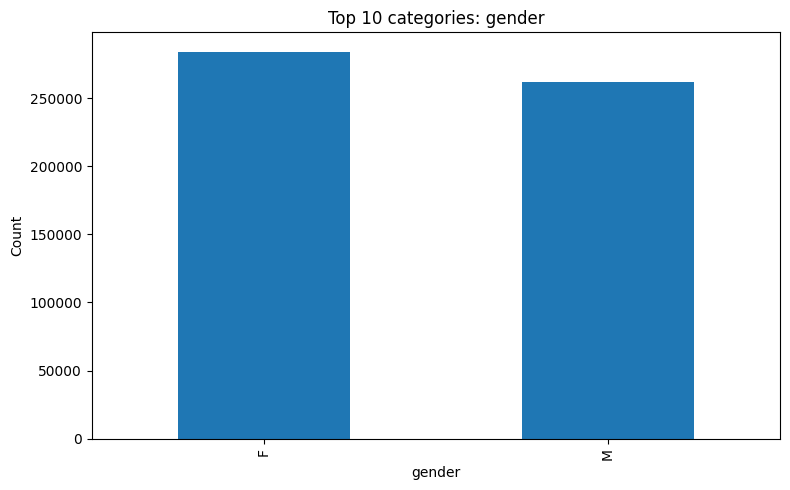

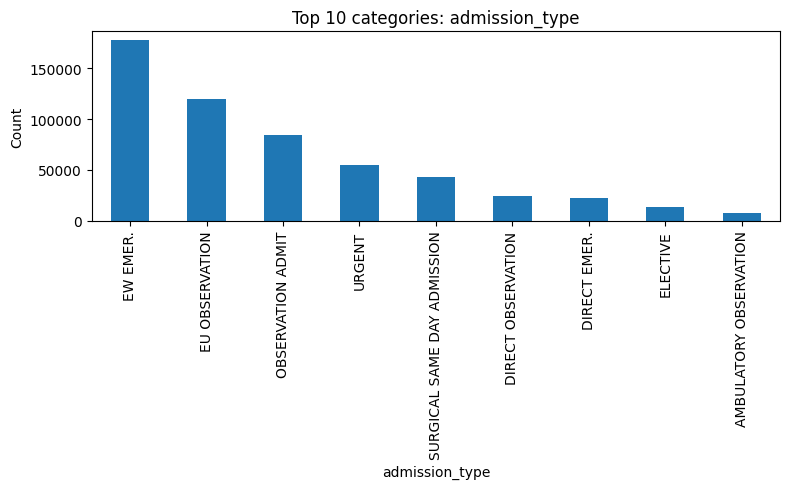

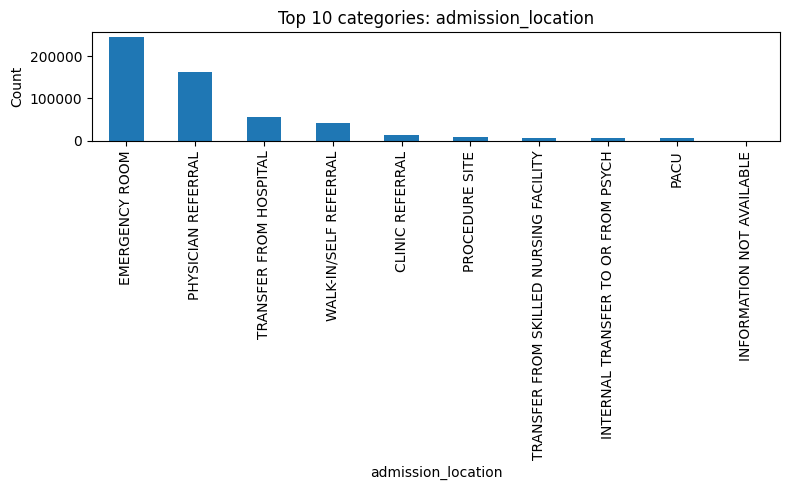

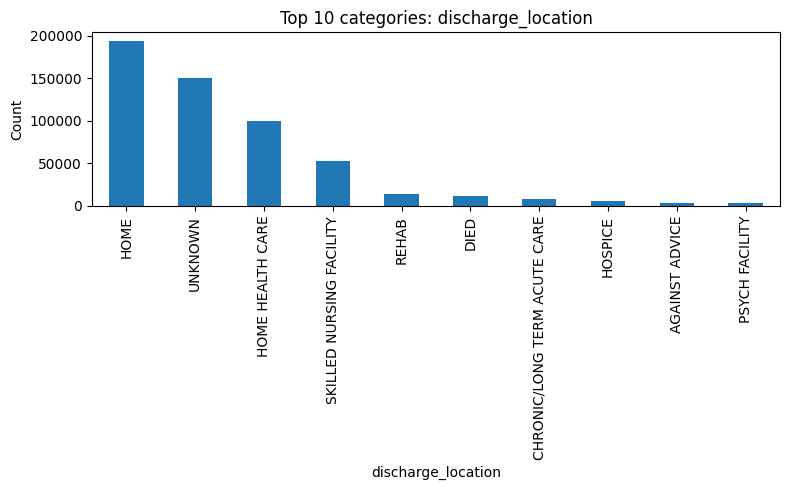

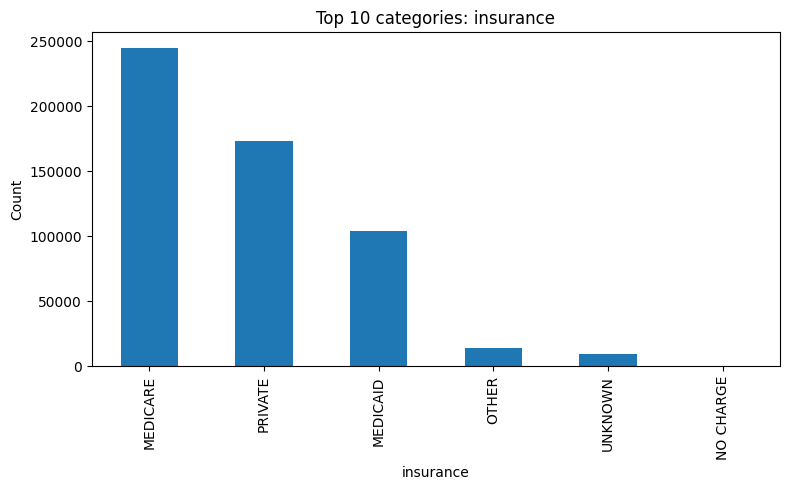

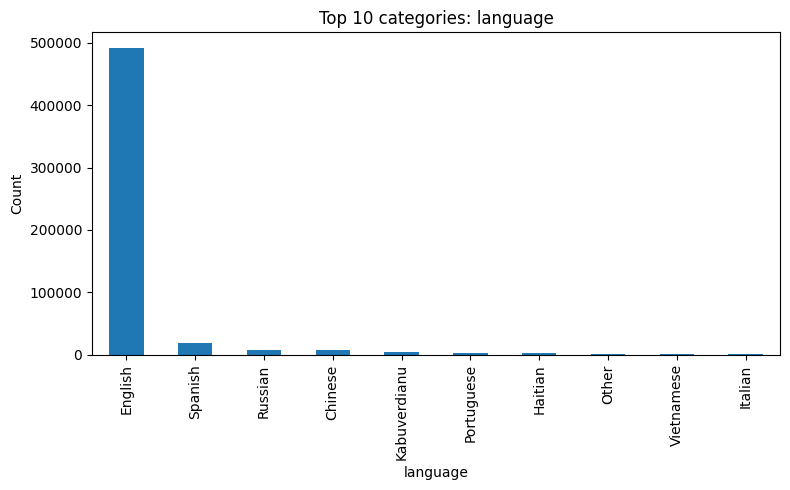

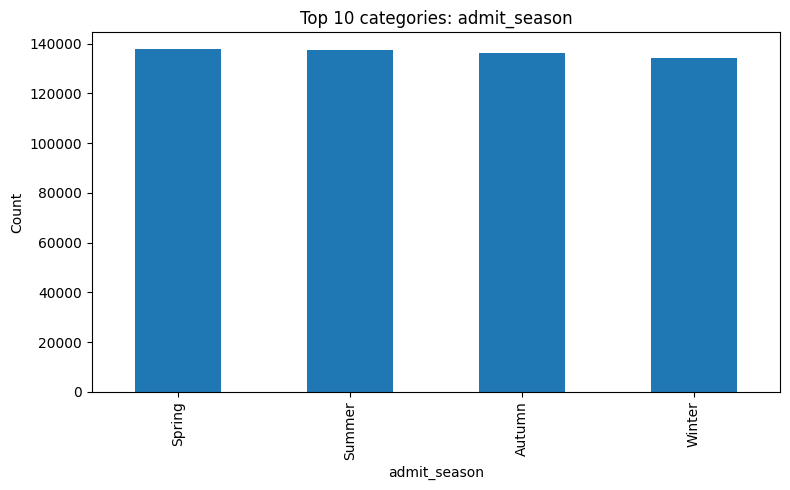

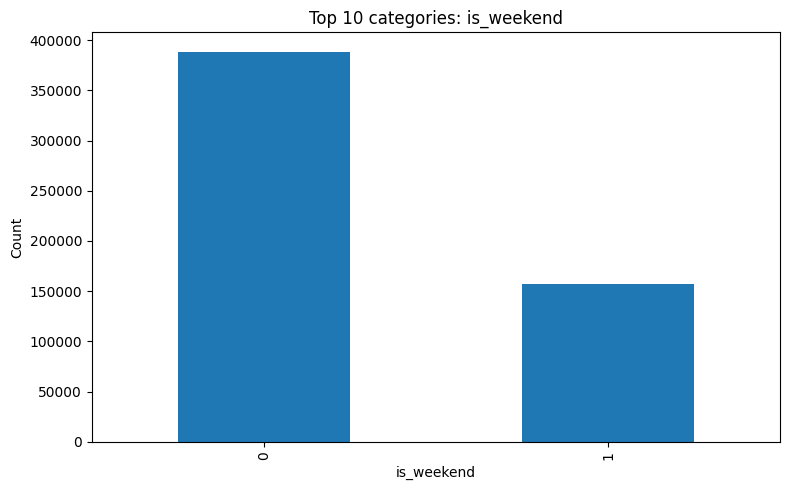

In [ ]:
# Key categorical distributions
for cat in ["gender","admission_type","admission_location","discharge_location",
            "insurance","language","admit_season","is_weekend"]:
    show_bar(cat, topn=10)

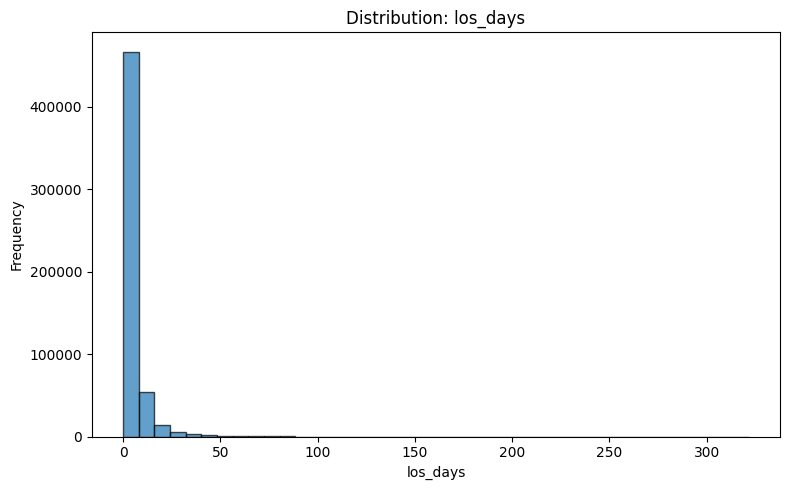

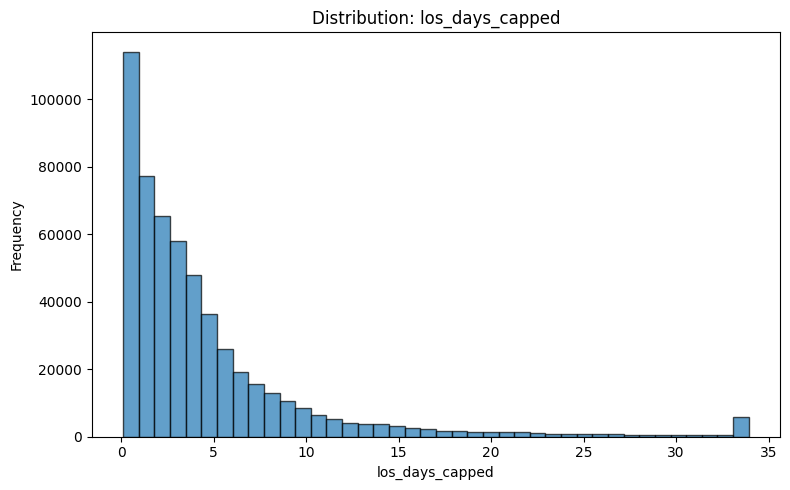

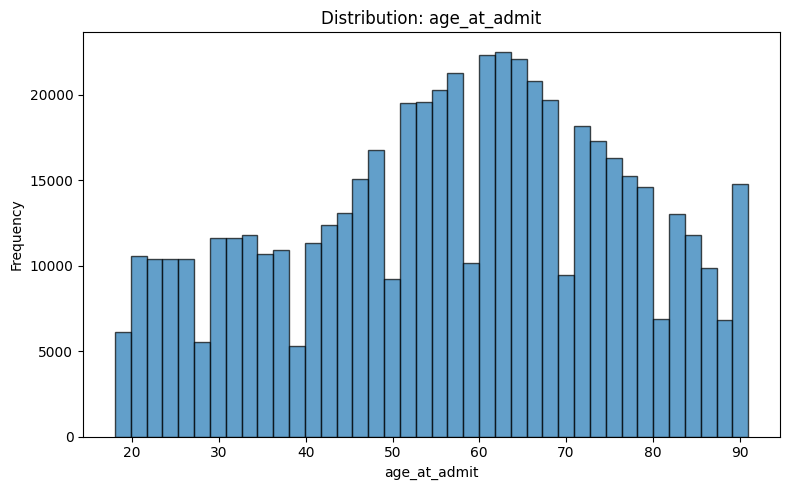

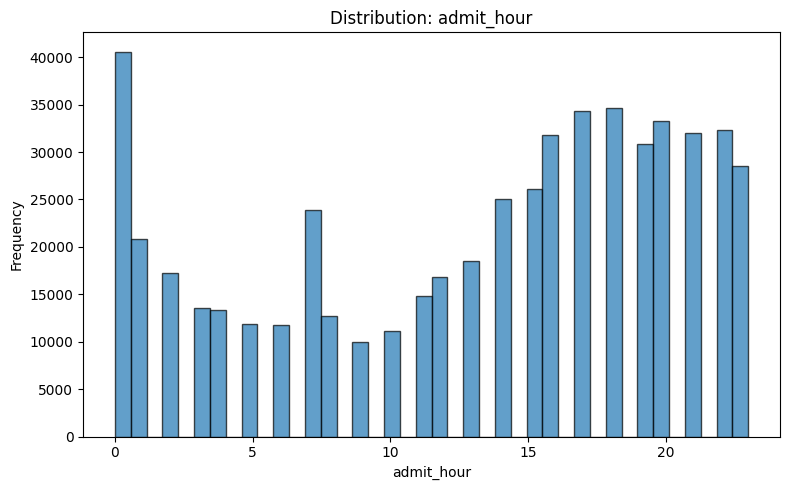

In [ ]:
# Important numerics
for num in ["los_days","los_days_capped","age_at_admit","admit_hour"]:
    show_hist(num, bins=40)

In [ ]:
# LOS by a few categories 
def group_describe(target, by):
    if target in merged.columns and by in merged.columns:
        print(f"\n{target} by {by}:")
        display(merged.groupby(by)[target].describe().sort_values("mean", ascending=False).head(20))

for by in ["admission_type","admission_location","discharge_location","insurance","ethnicity","is_weekend","admit_season"]:
    if by in merged.columns:
        group_describe("los_days", by)


los_days by admission_type:


,count,mean,std,min,25%,50%,75%,max
admission_type,,,,,,,,
DIRECT EMER.,21968.0,7.211545,9.253363,0.000000,2.756944,4.843056,7.993056,295.988194
URGENT,54910.0,7.001668,9.308790,0.002083,2.611111,4.127778,7.731250,226.538194
OBSERVATION ADMIT,84428.0,6.787541,8.402996,0.016667,2.777778,4.591667,7.798611,308.963889
ELECTIVE,13130.0,6.295253,8.027295,0.000694,2.539062,4.412847,6.489583,173.097917
EW EMER.,177381.0,5.908877,7.607985,0.000694,2.026389,3.793056,6.833333,321.579167
SURGICAL SAME DAY ADMISSION,42896.0,4.515839,4.984080,0.000000,2.100694,3.416667,5.405729,220.629861
DIRECT OBSERVATION,24545.0,1.311220,1.328758,0.000694,0.786111,1.037500,1.604167,128.584028
AMBULATORY OBSERVATION,7194.0,1.117670,0.652945,0.009028,0.795833,0.929167,1.161806,9.157639
EU OBSERVATION,119400.0,0.996057,1.191938,0.000000,0.388889,0.715278,1.143056,127.895833



los_days by admission_location:


,count,mean,std,min,25%,50%,75%,max
admission_location,,,,,,,,
UNKNOWN,1.0,49.904861,NaN,49.904861,49.904861,49.904861,49.904861,49.904861
INTERNAL TRANSFER TO OR FROM PSYCH,5837.0,12.028577,15.266493,0.002083,4.737500,7.111111,13.194444,203.328472
INFORMATION NOT AVAILABLE,400.0,8.098394,12.135925,0.011806,1.171701,4.068403,9.431250,111.581250
TRANSFER FROM HOSPITAL,56206.0,7.979489,10.279412,0.006250,2.546528,4.943403,9.632465,308.963889
TRANSFER FROM SKILLED NURSING FACILITY,6305.0,7.091705,9.046872,0.004861,2.097222,4.652083,8.600694,156.653472
AMBULATORY SURGERY TRANSFER,255.0,6.348156,7.472014,0.031944,2.121181,3.846528,7.613542,53.711806
CLINIC REFERRAL,12964.0,6.166284,9.009922,0.001389,1.873611,3.845833,7.020313,295.988194
PHYSICIAN REFERRAL,163205.0,4.760682,6.696477,0.000000,1.618056,3.093056,5.381250,321.579167
WALK-IN/SELF REFERRAL,42350.0,4.687737,7.285612,0.000694,0.942361,2.697917,5.658854,246.575694



los_days by discharge_location:


,count,mean,std,min,25%,50%,75%,max
discharge_location,,,,,,,,
CHRONIC/LONG TERM ACUTE CARE,8125.0,16.725865,17.191511,0.343750,6.040972,11.393750,21.599306,238.313889
REHAB,13845.0,11.463243,10.967892,0.003472,4.987500,8.008333,14.109028,249.585417
HOSPICE,5397.0,11.135838,11.437848,0.071528,4.054167,7.686111,13.825694,147.820833
DIED,11623.0,10.258834,14.251029,0.004861,2.090278,5.926389,13.169792,248.448611
ACUTE HOSPITAL,2334.0,9.212060,13.950258,0.011806,2.578993,5.135069,10.177951,207.152778
OTHER FACILITY,1592.0,8.654701,12.494231,0.022917,2.927778,5.428125,9.148264,157.041667
SKILLED NURSING FACILITY,52657.0,8.399024,8.691124,0.152083,3.840278,5.986806,9.776389,234.041667
PSYCH FACILITY,2965.0,7.765786,10.747181,0.002083,2.937500,5.046528,8.508333,176.859028
HOME HEALTH CARE,99304.0,6.756139,7.434738,0.015972,3.010417,4.900000,7.851389,321.579167



los_days by insurance:


,count,mean,std,min,25%,50%,75%,max
insurance,,,,,,,,
MEDICARE,244501.0,5.309629,7.239963,0.000000,1.549306,3.315278,6.425000,308.963889
OTHER,13995.0,4.713483,7.012493,0.000694,1.036458,2.711111,5.572222,127.854861
MEDICAID,104197.0,4.556241,7.871504,0.000000,0.899306,2.514583,5.013194,321.579167
PRIVATE,173362.0,4.196715,6.578654,0.000000,1.043056,2.529167,4.776389,295.988194
UNKNOWN,9334.0,3.409040,7.099438,0.001389,0.380729,1.044444,3.586458,153.832639
NO CHARGE,463.0,2.797453,4.915192,0.084722,0.802431,1.155556,2.628125,58.023611



los_days by is_weekend:


,count,mean,std,min,25%,50%,75%,max
is_weekend,,,,,,,,
1,157359.0,4.783466,7.157941,0.0,1.131944,2.822222,5.642361,246.575694
0,388493.0,4.753924,7.181148,0.0,1.128472,2.817361,5.615278,321.579167



los_days by admit_season:


,count,mean,std,min,25%,50%,75%,max
admit_season,,,,,,,,
Spring,137661.0,4.776926,7.161494,0.000694,1.134028,2.819444,5.636806,230.688889
Autumn,136386.0,4.771440,7.201199,0.000694,1.135417,2.822222,5.631944,295.988194
Winter,134175.0,4.764168,7.273145,0.000000,1.120833,2.815972,5.618056,308.963889
Summer,137630.0,4.737349,7.063199,0.000000,1.129167,2.818750,5.606771,321.579167



Correlation (selected numerics):
              los_days  age_at_admit  admit_hour  admit_month  is_weekend
los_days      1.000000      0.085352    0.024507     0.000535    0.001865
age_at_admit  0.085352      1.000000    0.056692     0.000853   -0.001129
admit_hour    0.024507      0.056692    1.000000     0.001294    0.003129
admit_month   0.000535      0.000853    0.001294     1.000000   -0.000794
is_weekend    0.001865     -0.001129    0.003129    -0.000794    1.000000


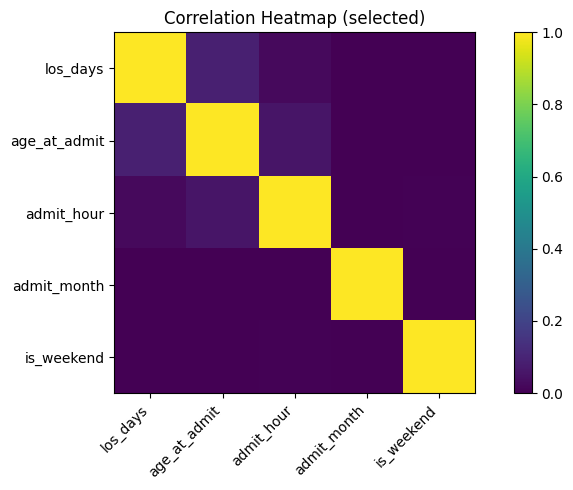

In [ ]:
# Simple correlation matrix of selected numeric features
num_cols = [c for c in ["los_days","age_at_admit","admit_hour","admit_month","is_weekend"] if c in merged.columns]
corr = merged[num_cols].corr()
print("\nCorrelation (selected numerics):")
print(corr)

plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Correlation Heatmap (selected)")
plt.tight_layout()
plt.show()

In [ ]:
# Minimal feature set for later modeling
# Select a compact, clean feature table for LOS or classification tasks later.
feat_cols = []
for c in ["age_at_admit","admit_hour","admit_month","is_weekend","los_days"]:
    if c in merged.columns:
        feat_cols.append(c)

# Keep a few common categoricals as dummies if present
cat_keep = [c for c in ["gender","admission_type","admission_location","insurance","ethnicity","admit_season"] if c in merged.columns]
X = merged[feat_cols + cat_keep].copy()

# One-hot encode chosen categoricals
X = pd.get_dummies(X, columns=cat_keep, drop_first=True)

# Simple numeric imputation (median) where needed
for col in X.columns:
    if X[col].dtype.kind in "iufc":  # numeric
        X[col] = X[col].fillna(X[col].median())

print("\nFeature matrix preview:")
display(X.head(5))


Feature matrix preview:


,age_at_admit,admit_hour,admit_month,is_weekend,los_days,gender_M,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT,admission_location_CLINIC REFERRAL,admission_location_EMERGENCY ROOM,admission_location_INFORMATION NOT AVAILABLE,admission_location_INTERNAL TRANSFER TO OR FROM PSYCH,admission_location_PACU,admission_location_PHYSICIAN REFERRAL,admission_location_PROCEDURE SITE,admission_location_TRANSFER FROM HOSPITAL,admission_location_TRANSFER FROM SKILLED NURSING FACILITY,admission_location_UNKNOWN,admission_location_WALK-IN/SELF REFERRAL,insurance_MEDICARE,insurance_NO CHARGE,insurance_OTHER,insurance_PRIVATE,insurance_UNKNOWN,admit_season_Spring,admit_season_Summer,admit_season_Winter
0,52,22,5,1,0.786111,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
1,52,18,6,0,1.015278,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,52,23,8,1,1.754167,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,52,12,7,1,2.222222,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,19,23,3,0,0.298611,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False


In [ ]:
# Persist Clean Outputs
merged.to_csv("data/admissions_clean.csv", index=False)
X.to_csv("data/admissions_features.csv", index=False)
print("\nSaved: admissions_clean.csv, admissions_features.csv")

# Cleanup
del admissions, patients, diagnoses, labevents, d_labitems
gc.collect()


Saved: admissions_clean.csv, admissions_features.csv


11053